**Open a Valve during a scan**

We want to do somthing to existing . For that we use prepocessors: https://nsls-ii.github.io/bluesky/plans.html#plan-preprocessors

We can see existing ones here: https://nsls-ii.github.io/bluesky/_modules/bluesky/preprocessors.html#suspend_wrapper

In [3]:
#configure a temp run engine environment

from bluesky import RunEngine

RE = RunEngine({})

from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

#Get the databroker https://gist.github.com/untzag/53281819709b1058c7708a250cbd3676
from databroker.v2 import temp
db = temp()

# Insert all metadata/data captured into db.
RE.subscribe(db.v1.insert)

1

In [2]:
from ophyd.sim import det, motor
from bluesky.plans import scan

In [14]:
# We can just add some moves around the existing scan plan
from bluesky.plan_stubs import mv

def scan_with_valve(detectors, *args, num=None, num_runs=None, per_step=None, md=None, valve=None):
    # Single-run plans may be called consecutively. No special handling is required
    #   as long as the previous scan is closed before the next one is opened
    
    yield from mv(valve,1)
    yield from scan(detectors, *args, num=None, per_step=None, md=None)
    yield from mv(valve,0)

In [15]:
#Let's test it with a simulated motor
from bessyii_devices.subclassed_device import Robot
dummy_axis = Robot('EMILEL:TestIOC00:',name='dummy_axis')



AxisTuple(done=0, setpoint=2.0, readback=2.0)



Transient Scan ID: 4     Time: 2021-08-31 15:16:46
Persistent Unique Scan ID: '560a7404-8d83-4533-9653-68c1e428f70a'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 15:16:46.0 |     -1.000 |      0.607 |
|         2 | 15:16:46.1 |     -0.778 |      0.739 |
|         3 | 15:16:46.1 |     -0.556 |      0.857 |
|         4 | 15:16:46.2 |     -0.333 |      0.946 |
|         5 | 15:16:46.2 |     -0.111 |      0.994 |
|         6 | 15:16:46.3 |      0.111 |      0.994 |
|         7 | 15:16:46.3 |      0.333 |      0.946 |
|         8 | 15:16:46.4 |      0.556 |      0.857 |
|         9 | 15:16:46.4 |      0.778 |      0.739 |
|        10 | 15:16:46.4 |      1.000 |      0.607 |
+-----------+------------+------------+------------+
generator scan ['560a7404'] (scan num: 4)





('560a7404-8d83-4533-9653-68c1e428f70a',)

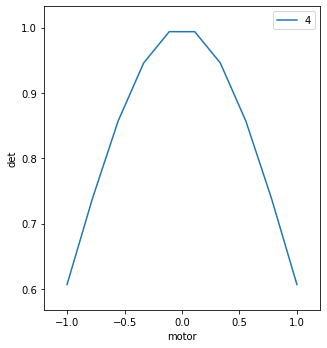

In [17]:
RE(scan_with_valve([det],motor,-1,1,10,valve=dummy_axis.axis_1))



Transient Scan ID: 5     Time: 2021-08-31 15:17:39
Persistent Unique Scan ID: '2c1c02f4-915a-4698-943f-72325d93a821'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 15:17:39.7 |     -1.000 |      0.607 |
|         2 | 15:17:39.8 |     -0.778 |      0.739 |
|         3 | 15:17:39.8 |     -0.556 |      0.857 |
|         4 | 15:17:39.9 |     -0.333 |      0.946 |
|         5 | 15:17:39.9 |     -0.111 |      0.994 |
|         6 | 15:17:40.0 |      0.111 |      0.994 |
|         7 | 15:17:40.0 |      0.333 |      0.946 |
|         8 | 15:17:40.0 |      0.556 |      0.857 |
|         9 | 15:17:40.1 |      0.778 |      0.739 |
|        10 | 15:17:40.1 |      1.000 |      0.607 |
+-----------+------------+------------+------------+
generator scan ['2c1c02f4'] (scan num: 5)





('2c1c02f4-915a-4698-943f-72325d93a821',)

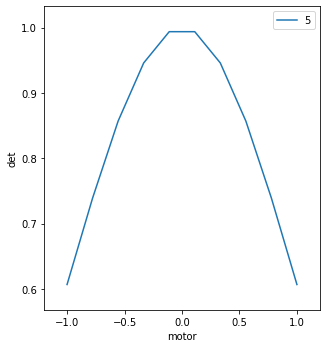

In [18]:
#We can also make it always connect to a particular valve

def emil_scan(detectors, *args, num=None, num_runs=None, per_step=None, md=None):
    # Single-run plans may be called consecutively. No special handling is required
    #   as long as the previous scan is closed before the next one is opened
    
    yield from mv(dummy_axis.axis_1,1)
    yield from scan(detectors, *args, num=None, per_step=None, md=None)
    yield from mv(dummy_axis.axis_1,0)

RE(emil_scan([det],motor,-1,1,10))


In [1]:
# We can make a special per step plan that includes moving the valves. 

from bluesky.plan_stubs import trigger_and_read, move_per_step
def one_nd_step_with_valves(detectors, step, pos_cache, take_reading=trigger_and_read):
    """
    Inner loop of an N-dimensional step scan

    This is the default function for ``per_step`` param`` in ND plans.

    Parameters
    ----------
    detectors : iterable
        devices to read
    step : dict
        mapping motors to positions in this step
    pos_cache : dict
        mapping motors to their last-set positions
    take_reading : plan, optional
        function to do the actual acquisition ::

           def take_reading(dets, name='primary'):
                yield from ...

        Callable[List[OphydObj], Optional[str]] -> Generator[Msg], optional

        Defaults to `trigger_and_read`
    """
    yield from mv(dummy_axis.axis_1,1)
    motors = step.keys()
    yield from move_per_step(step, pos_cache)
    yield from take_reading(list(detectors) + list(motors))
    yield from mv(dummy_axis.axis_1,0)
    


In [2]:
RE(scan([det],motor,-1,1,10,per_step=one_nd_step_with_valves))

NameError: name 'RE' is not defined

In [29]:
def onChanges(*,old_value,value,**kwargs):

    print(f"Value Changed from {old_value} to {value} ")
    
callback_id = dummy_axis.axis_1.readback.subscribe(onChanges,event_type=Signal.SUB_VALUE,run=False)


dummy_axis.axis_1.set(2)

NameError: name 'Signal' is not defined